An important problem with predicting retention indices (RI) using deep learning and machine learning is that the accuracy of the prediction for the certain group of molecules, and even more so for a specific molecule, remains unknown. By themselves, prediction algorithms such as gradient boosting and neural networks do not provide any estimate of accuracy or confidence interval. The accuracy estimates presented in related papers, including those of our team, were made using large data sets. Metrics such as the mean absolute error, calculated on test data sets including thousands and tens of thousands of molecules, provide little information since for some molecules (for example, alkane isomers) prediction is possible with excellent accuracy, and for other molecules, the prediction may be unsatisfactory. Thus, it is of great importance to develop methods to assess the accuracy of prediction for a specific molecule.

It can be done using molecular similarity. There are many methods that can be used to evaluate the similarity of two molecules. Typically, such methods are based on the similarity of “molecular fingerprints” or on finding common subgraphs (substructures) between molecules. “Molecular fingerprints” are vectors of bits, each of which indicates the presence of a particular fragment in a molecule.
The following hypothesis was tested: is it true that the closer the molecule to the given one was in the training set, the more accurate (on average) the prediction is. As a quantitative measure, we used the value of Smax, defined as the molecular similarity between the molecule in question for which the prediction is being made and the most similar molecule (having the highest molecular similarity value) from the training data set.

A comparison was made of two variants of algorithms for calculating molecular similarity, based on “molecular fingerprints” and two variants based on the size of the maximum common substructure. Options based on molecular fingerprints provide significantly better accuracy for assessing prediction accuracy. The best results have been achieved using molecular fingerprints such as ECFP. The following results were obtained for the NIST (polar stationary phases) database. If the Smax value does not exceed 0.5, then the average absolute error is 110 units, the proportion of molecules for which the absolute error is greater than 100: 31%. If Smax is greater than 0.5, then these values are 42 and 10%, respectively. If we use Smax as a predictor, the area under the specificity-sensitivity curve is 0.72. For non-polar stationary phases, this method also allows for estimation, the area under the curve is 0.74.

Each line of the data.txt file contains (separated by spaces): SMILES line, experimental RI predicted by the first RI model, predicted by the second RI model, cross-validation split number (starting from zero), numbers of 100 lines of the closest molecules (numbered starting from zero), included in other cross-validation splits. The file contains data from the copyright protected NIST library, we cannot make it publicly available. The file is created by Java program (see src folder). The word "closest" means "having the largest Tanimoto similarity of the binary ECFP molecular fingerprints with radius 3 (ECFP6) and length 1024". The preselection of 100 closest molecules was done by the java program.

In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdFMCS
from rdkit import rdBase
from rdkit.Chem import rdRascalMCES
from sklearn import metrics
import matplotlib.pyplot as plt
import rdkit.Chem.Draw as Draw
print(rdBase.rdkitVersion)

2023.09.5


In [3]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [6]:
# The Smax value for the query molecule. 
# Similarity = C/(A+B-C)   where A, B number of atoms in two molecules; C - number of atoms in largest common substructure
# ints - numbers (in array) of 100 preselected closest molecules
def similarity_mcs(query_mol, mols, ints):
    good_mols = [mols[i] for i in ints]
    numCommonAtoms = [rdFMCS.FindMCS([query_mol,mol_i]).numAtoms for mol_i in good_mols]
    numAtomsR = [mol_i.GetNumAtoms() for mol_i in good_mols]
    numAtomsQ = query_mol.GetNumAtoms()
    similarities = [numCommonAtoms[i]/(numAtomsR[i]+numAtomsQ-numCommonAtoms[i])  for i in range(0,len(good_mols))]
    return similarities

In [7]:
def similarity_rascal_one_pair_mols(mol1, mol2, options):
    result = rdRascalMCES.FindMCES(mol1,mol2,options)
    if len(result)==0:
        return 0
    return result[0].tier2Sim

# The Smax value for the query molecule (RasCal method)
# https://greglandrum.github.io/rdkit-blog/posts/2023-11-08-introducingrascalmces.html
# ints - numbers (in array) of 100 preselected closest molecules
def similarity_rascal(query_mol, mols, ints):
    good_mols = [mols[i] for i in ints]
    opts = rdRascalMCES.RascalOptions()
    opts.similarityThreshold = 0.0
    opts.returnEmptyMCES = True
    similarities = [similarity_rascal_one_pair_mols(query_mol,mol_i,opts) for mol_i in good_mols]
    return similarities

In [8]:
# The Smax value for the query molecule 
# ints - numbers (in array) of 100 preselected closest molecules
# fps - precompured fingerprints by RDkit,  fps = [fpgen.GetFingerprint(x) for x in mols]
# fpgen - RDKit fingerprints generator object
def similarity_fp(query_mol, fpgen, fps, ints):
    good_fps = [fps[i] for i in ints]
    fps_q = fpgen.GetFingerprint(query_mol)
    similarities = [DataStructs.TanimotoSimilarity(good_fps[i],fps_q) for i in range(0,len(good_fps))]
    return similarities

In [9]:
# Smax for all molecules, definition of data see above, mols = [Chem.MolFromSmiles(s) for s in data[0]]
def similarity_mcs_all_mols(data,mols,use_rascal_instead_mcs):
    sim_arr = []
    for j in range(0,len(data)):
        ints = [data.iloc[j][i+5] for i in range(0,100)]
        if use_rascal_instead_mcs:
            sim = max(similarity_rascal(mols[j],mols,ints))
        else:
            sim = max(similarity_mcs(mols[j],mols,ints))
        sim_arr = sim_arr+[sim]
        if j%500 == 0:
            print(j, end= ' ')

    print()
    return(sim_arr)    

In [10]:
# Smax for all molecules (fingerprints-based), definition of data see above, mols = [Chem.MolFromSmiles(s) for s in data[0]]
def similarity_fps_all_mols(data,mols,fpgen):
    fps = [fpgen.GetFingerprint(x) for x in mols]
    sim_arr = []
    for j in range(0,len(data)):
        ints = [data.iloc[j][i+5] for i in range(0,100)]
        sim = max(similarity_fp(mols[j],fpgen,fps,ints))
        sim_arr = sim_arr+[sim]
        if j%500 == 0:
            print(j, end= ' ')

    print()
    return(sim_arr)   

Loadind data and calculating Smax (see above)

In [11]:
data = pd.read_csv('./data.txt', sep=" ", header=None)
mols = [Chem.MolFromSmiles(s) for s in data[0]]

fpgen1 = AllChem.GetRDKitFPGenerator(fpSize=4096,maxPath=3)
fpgen2 = AllChem.GetRDKitFPGenerator(fpSize=4096,maxPath=6)
fpgen3 = AllChem.GetRDKitFPGenerator(fpSize=4096,maxPath=12)
fpgen4 = AllChem.GetRDKitFPGenerator(fpSize=4096,maxPath=15)

fpgen5 = AllChem.GetMorganGenerator(fpSize=4096,radius=3)
fpgen6 = AllChem.GetMorganGenerator(fpSize=4096,radius=6)
fpgen7 = AllChem.GetMorganGenerator(fpSize=4096,radius=12)

sim_mcs = similarity_mcs_all_mols(data, mols, False)
sim_rascal = similarity_mcs_all_mols(data, mols, True)

sim_rdkitfp3 = similarity_fps_all_mols(data, mols, fpgen1)
sim_rdkitfp6 = similarity_fps_all_mols(data, mols, fpgen2)
sim_rdkitfp12 = similarity_fps_all_mols(data, mols, fpgen3)
sim_rdkitfp15= similarity_fps_all_mols(data, mols, fpgen4)

sim_ecfp3 = similarity_fps_all_mols(data, mols, fpgen5)
sim_ecfp6 = similarity_fps_all_mols(data, mols, fpgen6)
sim_ecfp12 = similarity_fps_all_mols(data, mols, fpgen7)
data

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 


,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,C#CC(C)(CCCC(C)CCCC(C)C)O,1927.0,1991.6523,1911.4839,0,8404,8405,5827,2337,4237,...,2335,2336,2882,6814,8010,8545,4241,2738,4964,6511
1,C#CC(C)(CCCC(C)CCCC(C)CCCC(C)C)O,2319.0,2409.7607,2286.7288,0,8405,8404,5827,2337,4236,...,2336,2335,8010,6814,8545,2882,4241,2738,4964,6511
2,C#CC(CC)(C=CCl)O,1445.0,1756.6654,1670.2220,0,1882,3764,8398,8450,1883,...,3428,4082,5253,5645,5646,5647,6024,7530,7531,9040
3,C#CC=CCCCCCCCCC,1363.0,1486.0543,1535.7875,0,3147,4988,5015,6896,6898,...,5085,6917,6948,7748,7750,7754,7757,7759,7761,8827
4,C#CCCCO,1333.0,1421.2881,1480.2781,0,5648,7528,5649,1884,7575,...,7532,4918,2149,2340,2991,3125,4715,4723,4858,4990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9403,c1cnccc1C=O,1668.0,1724.1957,1817.8157,4,1824,3708,1849,1777,5642,...,2154,2521,7397,1933,1789,7413,4419,4478,5607,7351
9404,c1cncnc1,1303.0,1322.0427,1258.1056,4,3758,1880,1775,3650,5592,...,1875,3380,3553,4275,5640,7311,7437,1655,1836,4100
9405,c1cocn1,1019.0,972.5609,1222.2561,4,3666,1878,3763,1779,7446,...,7264,7270,7271,7313,7433,3724,4216,7467,305,625
9406,c1csc2cscc12,1975.0,1919.2864,1935.7238,4,1573,7481,7432,7525,7526,...,2921,4372,7340,508,5274,6733,571,901,5626,3874


In [14]:
df = pd.DataFrame(data[0])
df['Experimental']=data[1]
df['CNN'] = data[2]
df['MLP'] = data[3]
df['pred'] = (data[2]+data[3])/2
df['abs_error']=abs(df['pred']-df['Experimental'])
df['sim_mcs']=sim_mcs
df['sim_rascal']=sim_rascal
df['sim_ecfp']=sim_ecfp6
df['sim_rdkitfp']=sim_rdkitfp6
df.to_csv('data_fizhim.csv')

In [15]:
df = pd.read_csv('data_fizhim.csv')
df

,Unnamed: 0,0,Experimental,CNN,MLP,pred,abs_error,sim_mcs,sim_rascal,sim_ecfp,sim_rdkitfp
0,0,C#CC(C)(CCCC(C)CCCC(C)C)O,1927.0,1991.6523,1911.4839,1951.56810,24.56810,0.882353,0.936524,0.466667,0.632911
1,1,C#CC(C)(CCCC(C)CCCC(C)CCCC(C)C)O,2319.0,2409.7607,2286.7288,2348.24475,29.24475,0.909091,0.951814,0.520000,0.632911
2,2,C#CC(CC)(C=CCl)O,1445.0,1756.6654,1670.2220,1713.44370,268.44370,0.777778,0.768627,0.392857,0.428571
3,3,C#CC=CCCCCCCCCC,1363.0,1486.0543,1535.7875,1510.92090,147.92090,0.923077,0.921600,0.436364,0.727273
4,4,C#CCCCO,1333.0,1421.2881,1480.2781,1450.78310,117.78310,0.833333,0.846154,0.428571,0.583333
...,...,...,...,...,...,...,...,...,...,...,...
9403,9403,c1cnccc1C=O,1668.0,1724.1957,1817.8157,1771.00570,103.00570,1.000000,1.000000,0.434783,0.729730
9404,9404,c1cncnc1,1303.0,1322.0427,1258.1056,1290.07415,12.92585,0.857143,0.857143,0.400000,0.607143
9405,9405,c1cocn1,1019.0,972.5609,1222.2561,1097.40850,78.40850,0.833333,0.833333,0.235294,0.550725
9406,9406,c1csc2cscc12,1975.0,1919.2864,1935.7238,1927.50510,47.49490,1.000000,0.885813,0.333333,0.578947


0.6232203133291363
0.6934027609146917
0.7011173683713421
0.6852176547301341

0.7206628978103429
0.7214574160848964
0.7242965349424169

0.5474468898443783
0.6070798568891322


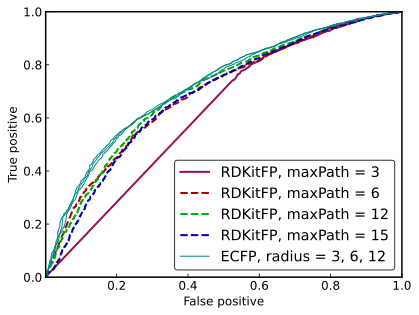

In [30]:
bad = df['abs_error']>100

f1, t1, _ = metrics.roc_curve(bad,sim_rdkitfp3)
f2, t2, _ = metrics.roc_curve(bad,sim_rdkitfp6)
f3, t3, _ = metrics.roc_curve(bad,sim_rdkitfp12)
f4, t4, _ = metrics.roc_curve(bad,sim_rdkitfp15)

f5, t5, _ = metrics.roc_curve(bad,sim_ecfp3)
f6, t6, _ = metrics.roc_curve(bad,sim_ecfp6)
f7, t7, _ = metrics.roc_curve(bad,sim_ecfp12)

_, ax = plt.subplots()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
plt.tick_params(axis='both', labelsize='large', direction='in')    
plt.xlim(0.001,1)
plt.ylim(0,1)
plt.plot(t1,f1, color='#991155ff', linewidth=2,linestyle='-',label='RDKitFP, maxPath = 3')
plt.plot(t2,f2, color='#AA0000ff', linewidth=2,linestyle='--', label='RDKitFP, maxPath = 6')
plt.plot(t3,f3, color='#00AA00ff', linewidth=2,linestyle='--', label='RDKitFP, maxPath = 12')
plt.plot(t4,f4, color='#0000AAff', linewidth=2,linestyle='--', label='RDKitFP, maxPath = 15')
plt.plot(t5,f5, color='#008888ff', linewidth=1, label='ECFP, radius = 3, 6, 12')
plt.plot(t6,f6, color='#008888ff', linewidth=1)
plt.plot(t7,f7, color='#008888ff', linewidth=1)
plt.legend(fontsize='x-large',edgecolor='#000000ff')
plt.xlabel("False positive", fontsize='large')
plt.ylabel("True positive", fontsize='large')
plt.savefig("fig_fizhim_rocauc.svg")

print(metrics.roc_auc_score(bad,np.subtract(1,sim_rdkitfp3)))
print(metrics.roc_auc_score(bad,np.subtract(1,sim_rdkitfp6)))
print(metrics.roc_auc_score(bad,np.subtract(1,sim_rdkitfp12)))
print(metrics.roc_auc_score(bad,np.subtract(1,sim_rdkitfp15)))
print()
print(metrics.roc_auc_score(bad,np.subtract(1,sim_ecfp3)))
print(metrics.roc_auc_score(bad,np.subtract(1,sim_ecfp6)))
print(metrics.roc_auc_score(bad,np.subtract(1,sim_ecfp12)))
print()
print(metrics.roc_auc_score(bad,np.subtract(1,sim_mcs)))
print(metrics.roc_auc_score(bad,np.subtract(1,sim_rascal)))


ROC curves, predcit if prediction error > 100 based only on one Smax value

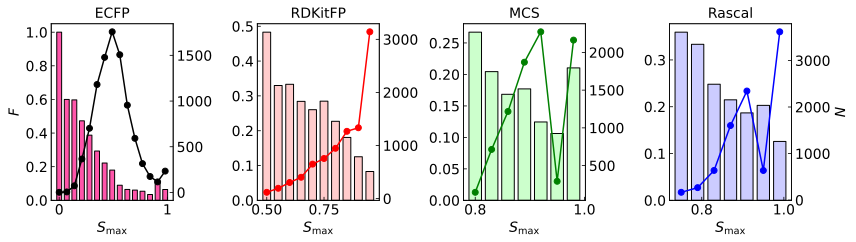

In [50]:
def fraction_bad_similarity(deviations, sim, threshold, range_percents):
    p1 = []
    h1 = []
    x1 = []
    y1 = []
    for i in range_percents:
        f = i/100
        s = range_percents.step/100
        n_total = sum((sim>f)&(sim<f+s+0.001))
        n_bad = sum((sim>f)&(sim<f+s+0.001)&(deviations>threshold))
        p1 = p1+[(i/100)]
        h1 = h1+[(n_bad/n_total)]
        y1 = y1 + [n_total]
        x1 = x1 + [i/100]

    return p1,h1,x1,y1

fig,ax = plt.subplots(1,4,figsize=(12, 3.5))


font_size=14
p1,h1,x1,y1 = fraction_bad_similarity(df['abs_error'],df['sim_ecfp'],100,range(0,100,7))
ax[0].tick_params(axis='both', labelsize=font_size, direction='in')    
ax[0].bar(p1,h1,align='center',width=0.045,color="#FF55AA",edgecolor='black')
ax1=ax[0].twinx()
ax[0].set_title('ECFP', fontsize=font_size)
ax[0].set_ylabel('$F$', fontsize=font_size)
ax1.tick_params(axis='both', labelsize=font_size, direction='in')    
ax1.plot(x1,y1, color='black', marker='o')
ax[0].set_xlabel('$S_{\mathregular{max}}$', fontsize=font_size)

p1,h1,x1,y1 = fraction_bad_similarity(df['abs_error'],df['sim_rdkitfp'],100,range(50,100,5))
ax[1].tick_params(axis='both', labelsize=font_size, direction='in')    
ax[1].bar(p1,h1,align='center',width=0.034,color="#FFCCCC",edgecolor='black')
ax1=ax[1].twinx()
ax[1].set_title('RDKitFP', fontsize=font_size)
ax1.tick_params(axis='both', labelsize=font_size, direction='in')    
ax1.plot(x1,y1, color='red', marker='o')
ax[1].set_xlabel('$S_{\mathregular{max}}$', fontsize=font_size)

p1,h1,x1,y1 = fraction_bad_similarity(df['abs_error'],df['sim_mcs'],100,range(80,100,3))
ax[2].tick_params(axis='both', labelsize=font_size, direction='in')    
ax[2].bar(p1,h1,align='center',width=0.023,color="#CCFFCC",edgecolor='black')
ax1=ax[2].twinx()
ax[2].set_title('MCS', fontsize=font_size)
ax1.tick_params(axis='both', labelsize=font_size, direction='in')    
ax1.plot(x1,y1, color='green', marker='o')
ax[2].set_xlabel('$S_{\mathregular{max}}$', fontsize=font_size)

p1,h1,x1,y1 = fraction_bad_similarity(df['abs_error'],df['sim_rascal'],100,range(75,100,4))
ax[3].tick_params(axis='both', labelsize=font_size, direction='in')    
ax[3].bar(p1,h1,align='center',width=0.03,color="#CCCCFF",edgecolor='black')
ax1=ax[3].twinx()
ax1.set_ylabel('$N$', fontsize=font_size)
ax[3].set_title('Rascal', fontsize=font_size)
ax1.tick_params(axis='both', labelsize=font_size, direction='in')    
ax1.plot(x1,y1, color='blue', marker='o')
ax[3].set_xlabel('$S_{\mathregular{max}}$', fontsize=font_size)

fig.tight_layout()
plt.savefig("fig_fizhim_1.svg")

Figure. The dependence of the total number of molecules N (lines) and the fraction of “poorly predicted molecules” (absolute prediction error greater than 100) F (rectangles) on the value of Smax.

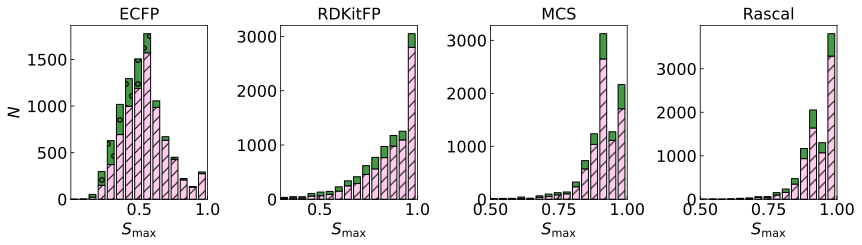

In [52]:
bad = df['abs_error']>100

fig,ax = plt.subplots(1,4,figsize=(12, 3.5))
font_size = 16
lowl = 0.0001
highl = 1.0
name = 'sim_ecfp'
ax[0].set_xlim(lowl,highl)
goods = df[name][bad==False]
bads = df[name][bad==True]
h_goods, p_goods = np.histogram(goods, range=(lowl,highl),bins=15)
h_bads, p_bads = np.histogram(bads, range=(lowl,highl),bins=15)
h_goods = np.hstack((h_goods,np.array([0])))
h_bads = np.hstack((h_bads,np.array([0])))
ax[0].bar(p_goods,h_goods,align='edge',width=0.05,color="#FFCCEE",edgecolor='black', hatch= '//')
ax[0].bar(p_bads,h_bads,align='edge',width=0.05,color="#449944",edgecolor='black',bottom = h_goods, hatch= 'o')
ax[0].set_xlabel('$S_{\mathregular{max}}$', fontsize=font_size)
ax[0].tick_params(axis='both', labelsize=font_size, direction='in')    
ax[0].set_ylabel('$N$', fontsize=font_size)
ax[0].set_title('ECFP', fontsize=font_size)

lowl = 0.3
highl = 1.0
name = 'sim_rdkitfp'
ax[1].set_xlim(lowl,highl)
goods = df[name][bad==False]
bads = df[name][bad==True]
h_goods, p_goods = np.histogram(goods, range=(lowl,highl),bins=15)
h_bads, p_bads = np.histogram(bads, range=(lowl,highl),bins=15)
h_goods = np.hstack((h_goods,np.array([0])))
h_bads = np.hstack((h_bads,np.array([0])))
ax[1].bar(p_goods,h_goods,align='edge',width=0.035,color="#FFCCEE",edgecolor='black', hatch= '//')
ax[1].bar(p_bads,h_bads,align='edge',width=0.035,color="#449944",edgecolor='black',bottom = h_goods)
ax[1].set_xlabel('$S_{\mathregular{max}}$', fontsize=font_size)
ax[1].tick_params(axis='both', labelsize=font_size, direction='in')    
ax[1].set_title('RDKitFP', fontsize=font_size)

lowl = 0.5
highl = 1.0
name = 'sim_mcs'
ax[2].set_xlim(lowl,highl)
goods = df[name][bad==False]
bads = df[name][bad==True]
h_goods, p_goods = np.histogram(goods, range=(lowl,highl),bins=15)
h_bads, p_bads = np.histogram(bads, range=(lowl,highl),bins=15)
h_goods = np.hstack((h_goods,np.array([0])))
h_bads = np.hstack((h_bads,np.array([0])))
ax[2].bar(p_goods,h_goods,align='edge',width=0.025,color="#FFCCEE",edgecolor='black', hatch= '//')
ax[2].bar(p_bads,h_bads,align='edge',width=0.025,color="#449944",edgecolor='black',bottom = h_goods)
ax[2].set_xlabel('$S_{\mathregular{max}}$', fontsize=font_size)
ax[2].tick_params(axis='both', labelsize=font_size, direction='in')    
ax[2].set_title('MCS', fontsize=font_size)

lowl = 0.5
highl = 1.0
name = 'sim_rascal'
ax[3].set_xlim(lowl,highl)
goods = df[name][bad==False]
bads = df[name][bad==True]
h_goods, p_goods = np.histogram(goods, range=(lowl,highl),bins=15)
h_bads, p_bads = np.histogram(bads, range=(lowl,highl),bins=15)
h_goods = np.hstack((h_goods,np.array([0])))
h_bads = np.hstack((h_bads,np.array([0])))
ax[3].bar(p_goods,h_goods,align='edge',width=0.025,color="#FFCCEE",edgecolor='black', hatch= '//')
ax[3].bar(p_bads,h_bads,align='edge',width=0.025,color="#449944",edgecolor='black',bottom = h_goods)
ax[3].set_xlabel('$S_{\mathregular{max}}$', fontsize=font_size)
ax[3].tick_params(axis='both', labelsize=font_size, direction='in')    
ax[3].set_title('Rascal', fontsize=font_size)

fig.tight_layout()
plt.savefig("fig_fizhim_2.svg")

Figure. Distribution of the number of molecules N in the NIST 17 retention index database (polar stationary phases) by Smax values (the measure of molecular similarity between the molecule in question and the closest molecule from the training set) for four molecular similarity calculation methods. Dark color indicates “poorly predicted molecules” (absolute prediction error greater than 100), light color indicates the remaining molecules.

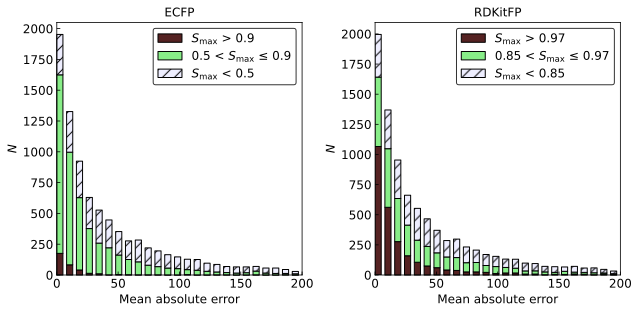

In [47]:
fig,ax = plt.subplots(1,2,figsize=(9, 4.5))
font_size = 12

name = 'sim_ecfp'
lowl = 0
highl = 200
ax[0].set_xlim(lowl,highl)
very_similar = df['abs_error'][df[name]>0.9]
moderately_similar = df['abs_error'][(df[name]<=0.9)&(df[name]>0.5)]
non_similar = df['abs_error'][(df[name]<0.5)]
h_vs, p_vs = np.histogram(very_similar, range=(lowl,highl),bins=25)
h_ms, p_ms = np.histogram(moderately_similar, range=(lowl,highl),bins=25)
h_ns, p_ns = np.histogram(non_similar, range=(lowl,highl),bins=25)
h_vs = np.hstack((h_vs,np.array([0])))
h_ms = np.hstack((h_ms,np.array([0])))
h_ns = np.hstack((h_ns,np.array([0])))
ax[0].bar(p_vs,h_vs,align='edge',width=5,color="#552222",edgecolor='black', label='$S_{\mathregular{max}}$ > 0.9')
ax[0].bar(p_ms,h_ms,align='edge',width=5,color="#88EE88",edgecolor='black',bottom = h_vs,label='0.5 < $S_{\mathregular{max}}$ ≤ 0.9')
ax[0].bar(p_ns,h_ns,align='edge',width=5,color="#EEEEFF",edgecolor='black',bottom = np.add(h_ms,h_vs), hatch= '//', label='$S_{\mathregular{max}}$ < 0.5')
ax[0].set_xlabel('Mean absolute error', fontsize=font_size)
ax[0].tick_params(axis='both', labelsize=font_size, direction='in')    
ax[0].set_ylabel('$N$', fontsize=font_size)
ax[0].set_title('ECFP', fontsize=font_size)
ax[0].legend(fontsize=font_size,edgecolor='#000000ff')


name = 'sim_rdkitfp'
lowl = 0
highl = 200
ax[1].set_xlim(lowl,highl)
very_similar = df['abs_error'][df[name]>0.97]
moderately_similar = df['abs_error'][(df[name]<=0.97)&(df[name]>0.85)]
non_similar = df['abs_error'][(df[name]<0.85)]
h_vs, p_vs = np.histogram(very_similar, range=(lowl,highl),bins=25)
h_ms, p_ms = np.histogram(moderately_similar, range=(lowl,highl),bins=25)
h_ns, p_ns = np.histogram(non_similar, range=(lowl,highl),bins=25)
h_vs = np.hstack((h_vs,np.array([0])))
h_ms = np.hstack((h_ms,np.array([0])))
h_ns = np.hstack((h_ns,np.array([0])))
ax[1].bar(p_vs,h_vs,align='edge',width=5,color="#552222",edgecolor='black', label='$S_{\mathregular{max}}$ > 0.97')
ax[1].bar(p_ms,h_ms,align='edge',width=5,color="#88EE88",edgecolor='black',bottom = h_vs,label='0.85 < $S_{\mathregular{max}}$ ≤ 0.97')
ax[1].bar(p_ns,h_ns,align='edge',width=5,color="#EEEEFF",edgecolor='black',bottom = np.add(h_ms,h_vs), hatch= '//', label='$S_{\mathregular{max}}$ < 0.85')
ax[1].set_xlabel('Mean absolute error', fontsize=font_size)
ax[1].tick_params(axis='both', labelsize=font_size, direction='in')    
ax[1].set_ylabel('$N$', fontsize=font_size)
ax[1].set_title('RDKitFP', fontsize=font_size)
ax[1].legend(fontsize=font_size,edgecolor='#000000ff')

fig.tight_layout()
plt.savefig("fig_fizhim_3.svg")

Figure. Distribution of the number of molecules N by absolute prediction error for various values of Smax (the measure of molecular similarity between the molecule in question and the closest molecule from the training set) for two methods for calculating molecular similarity.

In [16]:
smiles = ['CN1C=CC=N1','Cc1ccn(C)n1','CC1=CN(N=C1)C','CC1=NN(C=N1)C','CCN1C=NC=N1','CC(C)Nn1nccn1','CCN(C)N1C=NC=N1','CN1C=CN=N1','CN1C=NC=N1','CC1=NC=NN1C','CC1=CC(=NN1)C','CN1C=CC=C1N','CNCC1=NN(C=N1)C','CC1=CC=NN1','CN(C)CC(=O)N(C)C','CC1=NN(C=C1C#N)C','Cc1ncc(NN(C)C)cn1','CN(C)Nc1cnc(C)cn1','N\\C=CC(\\N)=C\\CNC','CN(C)C1=NC(=NC=C1)N(C)C','Cc1ccc(nn1)N(NC)CC','CN(C)\\N=C\\C=N\\C(=C)N=C','C=C(N)N\\N=C\\C=N','CC1=NC(=NC(=N1)N(C)C)N','CN1C=NC(=N1)N=CN(C)C','CN1C(=NC=N1)N=CN(C)C','Cn1cnnc1/N=C/N(C)C','NC(C)CNn1cncc1CN','CNC1=C([N](C=N1)[H])NCN(C)C','CN(C)CC(=O)N','CN(C)CC#N','CC(=O)NC','C=C(C)NN/C=N/N(C)C','CN(C)N\\C=N\\NC(C)=C','C/C=N/NCNCC(C)=O','COC1NC=NC1NN(C)C','CC(N)Cc1nnc(/N=C/N(C)C)n1C','Cn1nc(/N=C/N(C)C)nc1/N=C/N(C)C','Cn1c(nnc1/N=C/N(C)C)/N=C/N(C)C','Nc1ncnc2[nH]ccc12','Nc2cnc1[nH]ncc1c2']

In [17]:
def draw_many_mol(smiles_list,captions):
    mols = []
    for i in smiles_list:
        mols.append(Chem.MolFromSmiles(i))    
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300, 160), useSVG=True, legends=captions)

In [93]:
def string_ecfp6_similarities(data, mols, query_smiles):
    fpgen = AllChem.GetMorganGenerator(fpSize=4096,radius=6)
    fps = [fpgen.GetFingerprint(x) for x in mols]
    sim_arr = []
    for j in range(0,len(query_smiles)):
        sims=[]
        for fps1 in fps:
            fps_q = fpgen.GetFingerprint(Chem.MolFromSmiles(query_smiles[j]))
            similarity = DataStructs.TanimotoSimilarity(fps1,fps_q) 
            sims = sims + [similarity]

        sim_arr = sim_arr + ["{:10.2f}".format(max(sims))]
    return(sim_arr)   

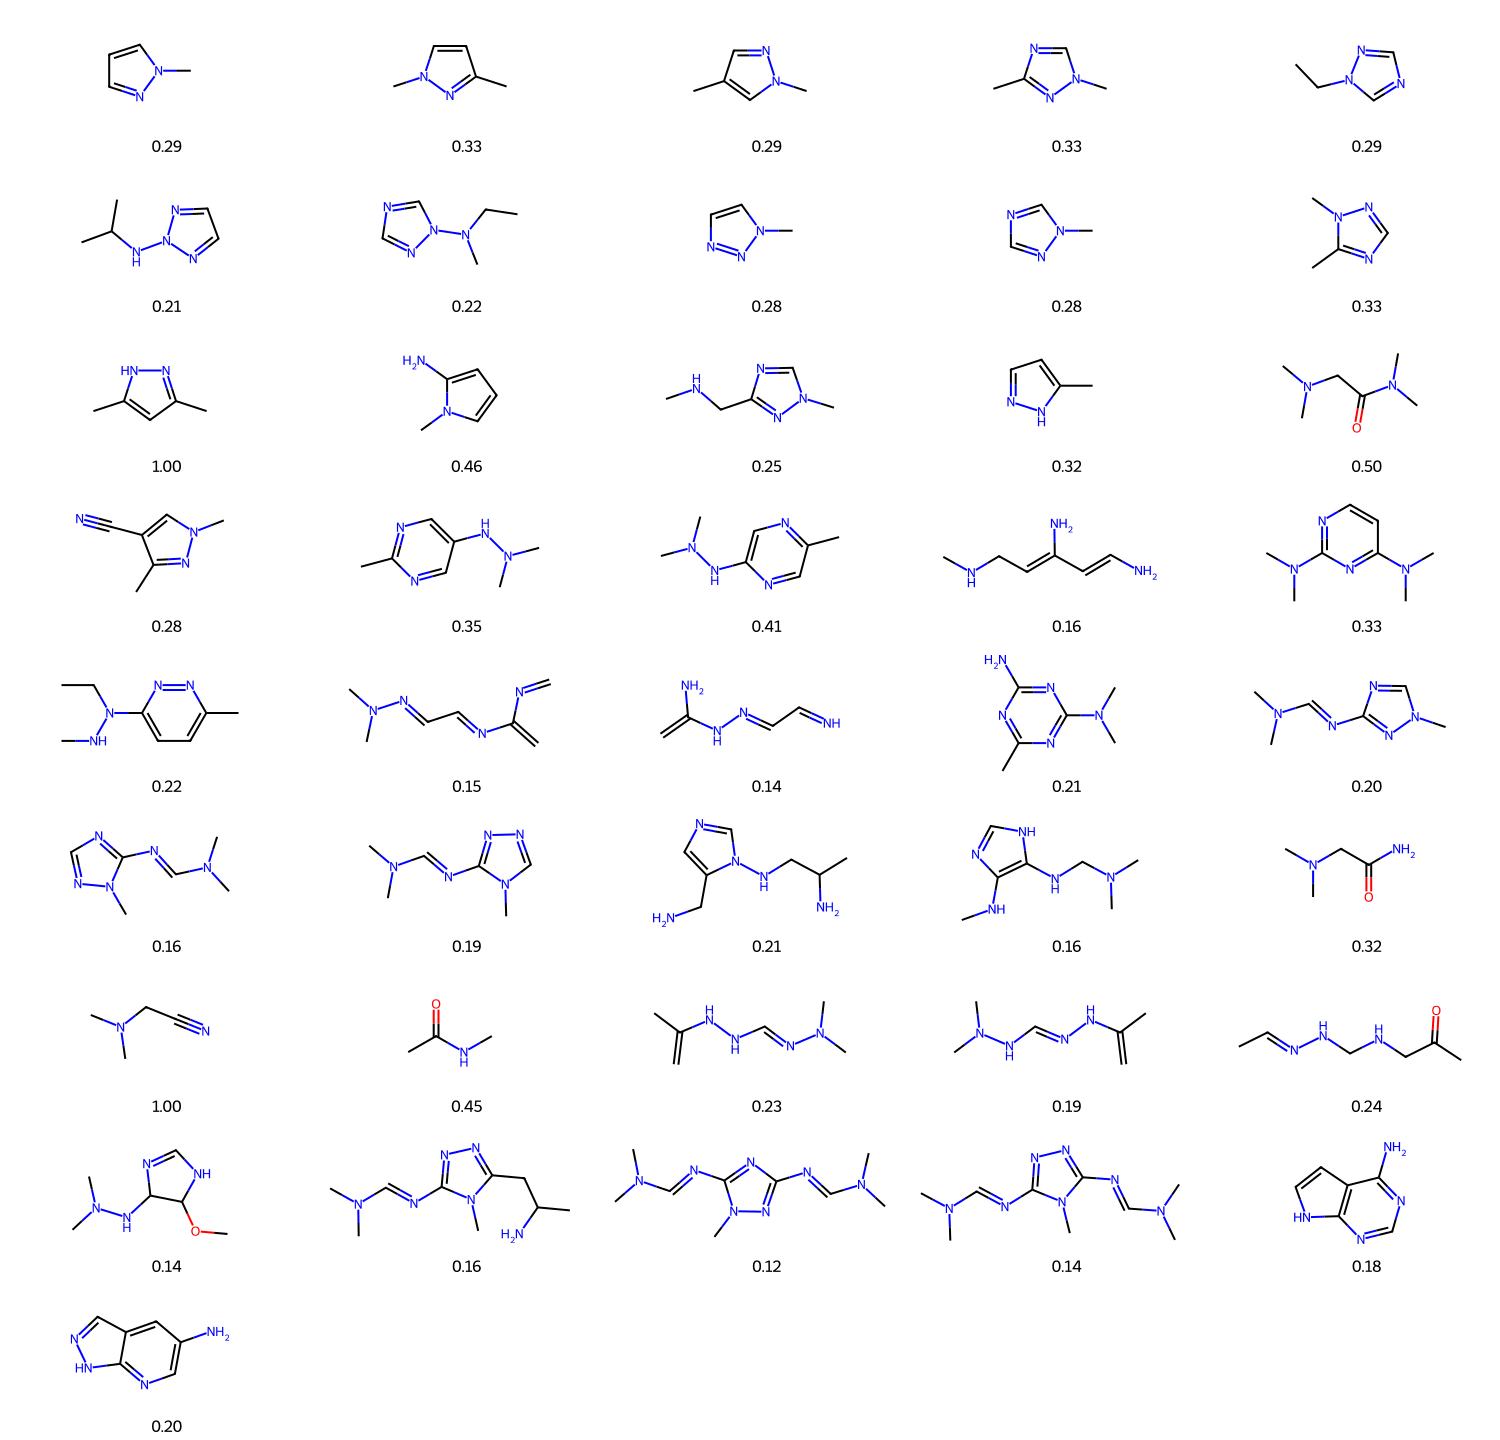

In [94]:
imgs0 = draw_many_mol(smiles, string_ecfp6_similarities(data, mols, smiles))
imgs = imgs0.data
imgs = imgs.replace("0000FF","000000")
imgs = imgs.replace("FF0000","000000")
with open("many_mols.svg", 'w') as f_handle:
    f_handle.write(imgs)

imgs0

In [67]:
print(sum(df['sim_ecfp']<0.2))
#print(sum(df['sim_ecfp']>=0.5))
print(sum((df['sim_ecfp']<0.2)&bad))
#print(sum((df['sim_ecfp']>=0.5)&bad))
print(30/50)

50
30
0.6


In [85]:
print(np.mean(df['abs_error']))
print(np.median(df['abs_error']))
print(np.mean(df['abs_error'][df['sim_ecfp']<2.2]))
print(np.median(df['abs_error'][df['sim_ecfp']<22.2]))


70.67173340826955
28.42832499999986
70.67173340826955
28.42832499999986
